## A simple overlap calculator

* define a voxel length
* define a volume
* define a density (cable/length per voxel) in the volume
* calculate the overlap of two densities

In [58]:
import numpy as np

In [99]:
def uniform(distance_to_foci):
    return np.ones(distance_to_foci.shape)

def get_gaussian(length_scale):
    def gaussian(distance_to_foci):
        return np.exp(-distance_to_foci**2/length_scale)
    return gaussian

class NeuralVolume:
    def __init__(self,x,y,z, voxel_size):
        self.x = x
        self.y = y
        self.z = z
        
        self.axes = tuple([np.arange(0,ax, voxel_size) for ax in [x,y,z]])
        self.mesh = np.meshgrid(*self.axes)
        
        self.mesh_shape = self.mesh[0].shape
        self.number_of_voxels = np.prod(self.mesh_shape)
        
    def get_coordinates(self):
        X, Y, Z = self.mesh
        number_of_elements = self.number_of_voxels
        return  np.vstack((X.reshape((number_of_elements,)), Y.reshape((number_of_elements,)), Z.reshape((number_of_elements,))))
        
    
class Ellipsoid:
    def __init__(self, center, r_long, r_small, long_axis):
        self.center = center
        self.r_long = r_long
        self.r_small = r_small
        self.long_axis = long_axis/np.sqrt(np.sum(long_axis*long_axis))
        
        distance_between_foci = 4*np.sqrt(r_long**2 - r_small**2)
        self.focus_1 = self.center - self.long_axis*distance_between_foci/2.0
        self.focus_2 = self.center + self.long_axis*distance_between_foci/2.0
        self.distance_to_foci = 2* r_long + distance_between_foci/2.0
    
    def get_density(self, volume, density=uniform):
        coordinates = volume.get_coordinates()
        distance_to_focus_1 = np.linalg.norm(coordinates - np.repeat(np.expand_dims(self.focus_1,axis=1), volume.number_of_voxels, axis=1), axis=0) 
        distance_to_focus_2 = np.linalg.norm(coordinates - np.repeat(np.expand_dims(self.focus_2,axis=1), volume.number_of_voxels, axis=1), axis=0)
        distance_to_foci = distance_to_focus_1+distance_to_focus_2

        density = np.where(distance_to_foci<self.distance_to_foci, density(distance_to_foci), np.zeros(distance_to_foci.shape))
        return density.reshape(volume.mesh_shape)/np.linalg.norm(density)

In [128]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_shapes(volume, densities):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim3d(0, volume.x)
    ax.set_ylim3d(0, volume.y)
    ax.set_zlim3d(0, volume.z)
    
    
    X, Y, Z = volume.mesh
    
    for density in densities:
        scatter_points = np.where(density>0.0)

        x_density = X[scatter_points]
        y_density = Y[scatter_points]
        z_density = Z[scatter_points]
    
        ax.scatter(x_density, y_density, z_density, alpha=0.5)

In [59]:
voxel_size = 2
v_x = 100
v_y = 100
v_z = 50

V = NeuralVolume(v_x, v_y, v_z, voxel_size)

In [154]:
axon_long_axis = np.array([0,0,1])
axon_long_axis = long_axis/ np.linalg.norm(long_axis)
axon_center=np.array([50, 50, 25])
axon_r_long = 20
axon_r_small = 3

dendrite_long_axis = np.array([1,1,0])
dendrite_long_axis = dendrite_long_axis/ np.linalg.norm(dendrite_long_axis)
dendrite_center=np.array([45, 45, 25])
dendrite_r_long = 8 
dendrite_r_small= 4

In [155]:
axon = Ellipsoid(axon_center, axon_r_long, axon_r_small, axon_long_axis)
dendrite = Ellipsoid(dendrite_center, dendrite_r_long, dendrite_r_small, dendrite_long_axis)
shapes = [axon, dendrite]

In [156]:
densities = [shape.get_density(V) for shape in shapes]

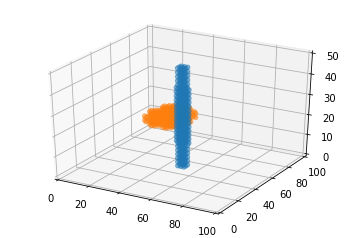

In [157]:
visualize_shapes(V, densities)

In [158]:
def overlap(density_1, density_2):
    return np.sum(density_1*density_2)

In [159]:
overlap(densities[0], densities[1])

0.2079385345810176